In [1]:
#導入函式
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
import os

import tensorflow as tf
import keras

In [2]:
tf.keras.__version__

'2.9.0'

In [3]:
tf.__version__

'2.9.0'

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
#匯入資料(csv需儲存在同資料夾下)
traindata = pd.read_csv('adult.train.txt', header=None,  names=["age","workclass","fnlwgt","education","education_num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","money"])
testdata = pd.read_csv('adult.test.txt', header=None,  names=["age","workclass","fnlwgt","education","education_num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","money"])

In [7]:
traindata

,age,workclass,fnlwgt,education,education_num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,money
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [8]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  money           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


# 前置處理

In [9]:
#將資料中含?的資料列刪除
traindata=traindata.replace(' ?', np.NaN)
traindata.dropna(inplace=True)
testdata=testdata.replace(' ?', np.NaN)
testdata.dropna(inplace=True)

In [10]:
#資料型態轉換
le=LabelEncoder()
for col in traindata[["workclass","education","marital-status","occupation","relationship","race","sex","native-country","money"]]:
    traindata[col]=le.fit_transform(traindata[col]).astype(np.float64)
for col in testdata[["workclass","education","marital-status","occupation","relationship","race","sex","native-country","money"]]:
    testdata[col]=le.fit_transform(testdata[col]).astype(np.float64)

In [11]:
#因為hours-per-week是之後要預測的變數，所以將X的hours-per-week欄位刪除
#X = train_data.drop('hours-per-week',axis=1)
#將hours-per-week欄位給y
#y = train_data['hours-per-week']
train_data = np.array(traindata.drop('hours-per-week',axis=1))
train_targets = np.array(traindata['hours-per-week'])
test_data = np.array(testdata.drop('hours-per-week',axis=1))
test_targets = np.array(testdata['hours-per-week'])

In [12]:
train_data.shape

(30162, 14)

In [13]:
test_data.shape

(15060, 14)

In [14]:
train_targets

array([40, 13, 40, ..., 40, 20, 40], dtype=int64)

# Normalization

In [15]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [16]:
train_data

array([[ 0.04279571,  2.93600035, -1.0627216 , ..., -0.21858598,
         0.26492394, -0.57569132],
       [ 0.88028814,  1.88768202, -1.00787131, ..., -0.21858598,
         0.26492394, -0.57569132],
       [-0.03333996, -0.20895464,  0.24469349, ..., -0.21858598,
         0.26492394, -0.57569132],
       ...,
       [ 1.48937355, -0.20895464, -0.3585745 , ..., -0.21858598,
         0.26492394, -0.57569132],
       [-1.25151078, -0.20895464,  0.11070545, ..., -0.21858598,
         0.26492394, -0.57569132],
       [ 1.0325595 ,  0.83936369,  0.92884082, ..., -0.21858598,
         0.26492394,  1.73704199]])

In [17]:
test_data

array([[-1.02310375, -0.20895464,  0.35028622, ..., -0.21858598,
         0.10113106, -0.57569132],
       [-0.03333996, -0.20895464, -0.94631973, ..., -0.21858598,
         0.10113106, -0.57569132],
       [-0.79469672, -1.25727297,  1.39285818, ..., -0.21858598,
         0.10113106,  1.73704199],
       ...,
       [-0.03333996, -0.20895464,  1.75283509, ..., -0.21858598,
         0.10113106, -0.57569132],
       [ 0.42347409, -0.20895464, -1.00238155, ..., -0.21858598,
         0.10113106, -0.57569132],
       [-0.26174699,  0.83936369, -0.07236863, ..., -0.21858598,
         0.10113106,  1.73704199]])

# Building network

In [18]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.summary()
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae', 'mse', 'mape'])
    return model

# Validating our approach using K-fold validation

In [17]:
import numpy as np

k = 3
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=1)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=1)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [19]:
all_scores

[7.556504726409912, 7.681415557861328, 7.386350631713867, 8.137068748474121]

In [20]:
np.mean(all_scores)

7.690334916114807

# ??

In [21]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

In [36]:
num_epochs = 150
all_mae_histories = []
for i in range(4):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=1)
   # mae_history = history.history['val_mean_absolute_error']
   # all_mae_histories.append(mae_history)

processing fold # 0
Epoch 1/500
22622/22622 [==============================] - 88s 4ms/step - loss: 146.2094 - mae: 8.2904 - val_loss: 126.8932 - val_mae: 7.9761
Epoch 2/500
22622/22622 [==============================] - 92s 4ms/step - loss: 125.1418 - mae: 7.7033 - val_loss: 120.8646 - val_mae: 7.7247
Epoch 3/500
22622/22622 [==============================] - 92s 4ms/step - loss: 121.8144 - mae: 7.6082 - val_loss: 120.5518 - val_mae: 7.4957
Epoch 4/500
22622/22622 [==============================] - 92s 4ms/step - loss: 121.0431 - mae: 7.5753 - val_loss: 117.7168 - val_mae: 7.5763
Epoch 5/500
22622/22622 [==============================] - 91s 4ms/step - loss: 120.0133 - mae: 7.5285 - val_loss: 117.2201 - val_mae: 7.5751
Epoch 6/500
22622/22622 [==============================] - 92s 4ms/step - loss: 120.0318 - mae: 7.5360 - val_loss: 123.0207 - val_mae: 7.6784
Epoch 7/500
22622/22622 [==============================] - 91s 4ms/step - loss: 119.5420 - mae: 7.4852 - val_loss: 114.3456 - va

22622/22622 [==============================] - 91s 4ms/step - loss: 115.7830 - mae: 7.3530 - val_loss: 115.2851 - val_mae: 7.6558
Epoch 116/500
22622/22622 [==============================] - 86s 4ms/step - loss: 116.3319 - mae: 7.3541 - val_loss: 121.0799 - val_mae: 7.5032
Epoch 117/500
22622/22622 [==============================] - 87s 4ms/step - loss: 115.9710 - mae: 7.3660 - val_loss: 118.0529 - val_mae: 7.3678
Epoch 118/500
22622/22622 [==============================] - 85s 4ms/step - loss: 116.0881 - mae: 7.3580 - val_loss: 118.2228 - val_mae: 7.5396
Epoch 119/500
22622/22622 [==============================] - 89s 4ms/step - loss: 116.3228 - mae: 7.3612 - val_loss: 115.7715 - val_mae: 7.5046
Epoch 120/500
22622/22622 [==============================] - 86s 4ms/step - loss: 116.1777 - mae: 7.3566 - val_loss: 125.0813 - val_mae: 7.6016
Epoch 121/500
22622/22622 [==============================] - 85s 4ms/step - loss: 116.1071 - mae: 7.3678 - val_loss: 120.5815 - val_mae: 7.5447
Epoch 

Epoch 172/500
22622/22622 [==============================] - 85s 4ms/step - loss: 115.6051 - mae: 7.3308 - val_loss: 116.3266 - val_mae: 7.5888
Epoch 173/500
22622/22622 [==============================] - 86s 4ms/step - loss: 116.2687 - mae: 7.3334 - val_loss: 117.1910 - val_mae: 7.5903
Epoch 174/500
22622/22622 [==============================] - 85s 4ms/step - loss: 115.8735 - mae: 7.3159 - val_loss: 116.9478 - val_mae: 7.4086
Epoch 175/500
22622/22622 [==============================] - 86s 4ms/step - loss: 115.9932 - mae: 7.3448 - val_loss: 118.1473 - val_mae: 7.4368
Epoch 176/500
22622/22622 [==============================] - 87s 4ms/step - loss: 115.4772 - mae: 7.3310 - val_loss: 117.5539 - val_mae: 7.7033
Epoch 177/500
22622/22622 [==============================] - 85s 4ms/step - loss: 115.9218 - mae: 7.3323 - val_loss: 115.9530 - val_mae: 7.5295
Epoch 178/500
22622/22622 [==============================] - 90s 4ms/step - loss: 115.4419 - mae: 7.3192 - val_loss: 122.1487 - val_mae:

Epoch 229/500
22622/22622 [==============================] - 86s 4ms/step - loss: 118.2188 - mae: 7.4464 - val_loss: 118.1985 - val_mae: 7.7366
Epoch 230/500
22622/22622 [==============================] - 84s 4ms/step - loss: 118.3732 - mae: 7.4384 - val_loss: 128.0234 - val_mae: 8.1423
Epoch 231/500
22622/22622 [==============================] - 86s 4ms/step - loss: 118.2386 - mae: 7.4461 - val_loss: 121.1535 - val_mae: 7.9157
Epoch 232/500
22622/22622 [==============================] - 91s 4ms/step - loss: 118.3443 - mae: 7.4518 - val_loss: 119.0120 - val_mae: 7.6692
Epoch 233/500
22622/22622 [==============================] - 86s 4ms/step - loss: 118.2075 - mae: 7.4516 - val_loss: 116.4038 - val_mae: 7.4492
Epoch 234/500
22622/22622 [==============================] - 86s 4ms/step - loss: 118.5712 - mae: 7.4591 - val_loss: 124.2809 - val_mae: 8.0921
Epoch 235/500
22622/22622 [==============================] - 85s 4ms/step - loss: 119.1315 - mae: 7.4949 - val_loss: 119.1182 - val_mae:

Epoch 286/500
22622/22622 [==============================] - 86s 4ms/step - loss: 124.2894 - mae: 7.6974 - val_loss: 126.4986 - val_mae: 8.1004
Epoch 287/500
22622/22622 [==============================] - 87s 4ms/step - loss: 124.9869 - mae: 7.7026 - val_loss: 122.7829 - val_mae: 7.8910
Epoch 288/500
22622/22622 [==============================] - 85s 4ms/step - loss: 124.9922 - mae: 7.7419 - val_loss: 122.0212 - val_mae: 7.7257
Epoch 289/500
22622/22622 [==============================] - 86s 4ms/step - loss: 125.7786 - mae: 7.7520 - val_loss: 136.1716 - val_mae: 8.3863
Epoch 290/500
22622/22622 [==============================] - 85s 4ms/step - loss: 124.8950 - mae: 7.7184 - val_loss: 139.6559 - val_mae: 8.4436
Epoch 291/500
22622/22622 [==============================] - 86s 4ms/step - loss: 125.0906 - mae: 7.7218 - val_loss: 122.2951 - val_mae: 7.7192
Epoch 292/500
22622/22622 [==============================] - 85s 4ms/step - loss: 124.8751 - mae: 7.7189 - val_loss: 128.2545 - val_mae:

Epoch 343/500
22622/22622 [==============================] - 85s 4ms/step - loss: 121.2960 - mae: 7.5345 - val_loss: 120.8213 - val_mae: 7.5088
Epoch 344/500
22622/22622 [==============================] - 84s 4ms/step - loss: 121.0761 - mae: 7.5311 - val_loss: 131.2726 - val_mae: 8.2920
Epoch 345/500
22622/22622 [==============================] - 85s 4ms/step - loss: 121.2110 - mae: 7.5481 - val_loss: 150.2425 - val_mae: 8.8773
Epoch 346/500
22622/22622 [==============================] - 87s 4ms/step - loss: 121.8582 - mae: 7.5383 - val_loss: 123.9917 - val_mae: 7.5235
Epoch 347/500
22622/22622 [==============================] - 83s 4ms/step - loss: 120.6940 - mae: 7.4962 - val_loss: 126.2277 - val_mae: 7.6347
Epoch 348/500
22622/22622 [==============================] - 86s 4ms/step - loss: 120.9337 - mae: 7.5039 - val_loss: 123.4783 - val_mae: 7.6024
Epoch 349/500
22622/22622 [==============================] - 84s 4ms/step - loss: 121.6445 - mae: 7.5058 - val_loss: 129.5950 - val_mae:

Epoch 400/500
22622/22622 [==============================] - 93s 4ms/step - loss: 114.4565 - mae: 7.0741 - val_loss: 112.7347 - val_mae: 7.2328
Epoch 401/500
22622/22622 [==============================] - 84s 4ms/step - loss: 113.8798 - mae: 7.0853 - val_loss: 114.4174 - val_mae: 7.3261
Epoch 402/500
22622/22622 [==============================] - 86s 4ms/step - loss: 113.8337 - mae: 7.0655 - val_loss: 120.6006 - val_mae: 7.6421
Epoch 403/500
22622/22622 [==============================] - 85s 4ms/step - loss: 113.8023 - mae: 7.0827 - val_loss: 112.7256 - val_mae: 7.2638
Epoch 404/500
22622/22622 [==============================] - 85s 4ms/step - loss: 113.6181 - mae: 7.0918 - val_loss: 113.9580 - val_mae: 7.1260
Epoch 405/500
22622/22622 [==============================] - 86s 4ms/step - loss: 113.6781 - mae: 7.0847 - val_loss: 115.5712 - val_mae: 7.1616
Epoch 406/500
22622/22622 [==============================] - 85s 4ms/step - loss: 113.3351 - mae: 7.0743 - val_loss: 115.9886 - val_mae:

Epoch 457/500
22622/22622 [==============================] - 85s 4ms/step - loss: 113.2331 - mae: 7.1306 - val_loss: 114.5913 - val_mae: 7.2261
Epoch 458/500
22622/22622 [==============================] - 91s 4ms/step - loss: 112.6709 - mae: 7.1245 - val_loss: 115.4165 - val_mae: 7.3227
Epoch 459/500
22622/22622 [==============================] - 85s 4ms/step - loss: 112.7946 - mae: 7.1375 - val_loss: 121.2074 - val_mae: 7.8149
Epoch 460/500
22622/22622 [==============================] - 86s 4ms/step - loss: 113.6242 - mae: 7.1543 - val_loss: 116.4300 - val_mae: 7.3620
Epoch 461/500
22622/22622 [==============================] - 84s 4ms/step - loss: 113.3869 - mae: 7.1537 - val_loss: 117.3113 - val_mae: 7.4066
Epoch 462/500
22622/22622 [==============================] - 86s 4ms/step - loss: 112.8160 - mae: 7.1405 - val_loss: 115.2229 - val_mae: 7.2218
Epoch 463/500
22622/22622 [==============================] - 85s 4ms/step - loss: 113.3714 - mae: 7.1585 - val_loss: 116.9071 - val_mae:

Epoch 14/500
22622/22622 [==============================] - 85s 4ms/step - loss: 116.2406 - mae: 7.3831 - val_loss: 115.3463 - val_mae: 7.2512
Epoch 15/500
22622/22622 [==============================] - 85s 4ms/step - loss: 116.2701 - mae: 7.3831 - val_loss: 115.9989 - val_mae: 7.4475
Epoch 16/500
22622/22622 [==============================] - 87s 4ms/step - loss: 115.4796 - mae: 7.3466 - val_loss: 119.8896 - val_mae: 7.3243
Epoch 17/500
22622/22622 [==============================] - 87s 4ms/step - loss: 115.6671 - mae: 7.3437 - val_loss: 113.9747 - val_mae: 7.2456
Epoch 18/500
22622/22622 [==============================] - 84s 4ms/step - loss: 114.8260 - mae: 7.3275 - val_loss: 121.7802 - val_mae: 7.4277
Epoch 19/500
22622/22622 [==============================] - 84s 4ms/step - loss: 114.8169 - mae: 7.3139 - val_loss: 114.8305 - val_mae: 7.2487
Epoch 20/500
22622/22622 [==============================] - 86s 4ms/step - loss: 114.2435 - mae: 7.3017 - val_loss: 114.9757 - val_mae: 7.4957

22622/22622 [==============================] - 87s 4ms/step - loss: 112.8409 - mae: 7.2268 - val_loss: 120.6615 - val_mae: 7.2486
Epoch 129/500
22622/22622 [==============================] - 88s 4ms/step - loss: 112.7989 - mae: 7.2452 - val_loss: 118.4149 - val_mae: 7.2880
Epoch 130/500
22622/22622 [==============================] - 85s 4ms/step - loss: 112.5815 - mae: 7.2331 - val_loss: 120.1404 - val_mae: 7.7031
Epoch 131/500
22622/22622 [==============================] - 86s 4ms/step - loss: 112.7090 - mae: 7.2327 - val_loss: 115.2961 - val_mae: 7.3147
Epoch 132/500
22622/22622 [==============================] - 84s 4ms/step - loss: 112.1597 - mae: 7.2335 - val_loss: 116.9374 - val_mae: 7.4591
Epoch 133/500
22622/22622 [==============================] - 86s 4ms/step - loss: 112.1007 - mae: 7.2217 - val_loss: 117.6067 - val_mae: 7.1574
Epoch 134/500
22622/22622 [==============================] - 85s 4ms/step - loss: 112.4739 - mae: 7.2231 - val_loss: 117.7779 - val_mae: 7.5272
Epoch 

Epoch 185/500
22622/22622 [==============================] - 84s 4ms/step - loss: 111.5632 - mae: 7.2102 - val_loss: 116.5153 - val_mae: 7.2697
Epoch 186/500
22622/22622 [==============================] - 84s 4ms/step - loss: 111.1914 - mae: 7.2144 - val_loss: 116.2938 - val_mae: 7.3799
Epoch 187/500
22622/22622 [==============================] - 86s 4ms/step - loss: 111.2943 - mae: 7.2242 - val_loss: 115.3936 - val_mae: 7.3812
Epoch 188/500
22622/22622 [==============================] - 93s 4ms/step - loss: 111.2552 - mae: 7.2208 - val_loss: 118.0524 - val_mae: 7.3645
Epoch 189/500
22622/22622 [==============================] - 86s 4ms/step - loss: 111.5240 - mae: 7.2399 - val_loss: 117.3663 - val_mae: 7.5570
Epoch 190/500
22622/22622 [==============================] - 85s 4ms/step - loss: 110.8768 - mae: 7.2296 - val_loss: 121.5000 - val_mae: 7.3866
Epoch 191/500
22622/22622 [==============================] - 86s 4ms/step - loss: 111.2315 - mae: 7.2257 - val_loss: 119.4634 - val_mae:

Epoch 242/500
22622/22622 [==============================] - 88s 4ms/step - loss: 112.2018 - mae: 7.2993 - val_loss: 119.9558 - val_mae: 7.4808
Epoch 243/500
22622/22622 [==============================] - 87s 4ms/step - loss: 112.4159 - mae: 7.3179 - val_loss: 117.1276 - val_mae: 7.5773
Epoch 244/500
22622/22622 [==============================] - 90s 4ms/step - loss: 112.2292 - mae: 7.3041 - val_loss: 123.7420 - val_mae: 7.5882
Epoch 245/500
22622/22622 [==============================] - 91s 4ms/step - loss: 111.8470 - mae: 7.2760 - val_loss: 137.1143 - val_mae: 8.2464
Epoch 246/500
22622/22622 [==============================] - 90s 4ms/step - loss: 112.3984 - mae: 7.3056 - val_loss: 122.1505 - val_mae: 7.9133
Epoch 247/500
22622/22622 [==============================] - 95s 4ms/step - loss: 112.1312 - mae: 7.2887 - val_loss: 116.9541 - val_mae: 7.5406
Epoch 248/500
22622/22622 [==============================] - 91s 4ms/step - loss: 112.0777 - mae: 7.2794 - val_loss: 119.0179 - val_mae:

Epoch 299/500
22622/22622 [==============================] - 95s 4ms/step - loss: 128.7376 - mae: 8.0546 - val_loss: 134.7056 - val_mae: 7.9958
Epoch 300/500
22622/22622 [==============================] - 88s 4ms/step - loss: 127.4607 - mae: 8.0186 - val_loss: 137.8378 - val_mae: 8.3814
Epoch 301/500
22622/22622 [==============================] - 90s 4ms/step - loss: 128.0935 - mae: 8.0467 - val_loss: 135.6563 - val_mae: 8.2283
Epoch 302/500
22622/22622 [==============================] - 86s 4ms/step - loss: 128.4712 - mae: 8.0623 - val_loss: 132.9911 - val_mae: 8.4263
Epoch 303/500
22622/22622 [==============================] - 89s 4ms/step - loss: 128.3942 - mae: 8.0435 - val_loss: 139.9230 - val_mae: 8.5711
Epoch 304/500
22622/22622 [==============================] - 91s 4ms/step - loss: 128.0749 - mae: 8.0629 - val_loss: 133.1419 - val_mae: 8.1806
Epoch 305/500
22622/22622 [==============================] - 89s 4ms/step - loss: 128.1836 - mae: 8.0684 - val_loss: 133.3596 - val_mae:

Epoch 356/500
22622/22622 [==============================] - 86s 4ms/step - loss: 140.5789 - mae: 8.5060 - val_loss: 167.9985 - val_mae: 9.1482
Epoch 357/500
22622/22622 [==============================] - 88s 4ms/step - loss: 141.0685 - mae: 8.5241 - val_loss: 144.7385 - val_mae: 8.5419
Epoch 358/500
22622/22622 [==============================] - 86s 4ms/step - loss: 140.6738 - mae: 8.5380 - val_loss: 152.6662 - val_mae: 8.7943
Epoch 359/500
22622/22622 [==============================] - 90s 4ms/step - loss: 140.7499 - mae: 8.5105 - val_loss: 145.0381 - val_mae: 8.3262
Epoch 360/500
22622/22622 [==============================] - 85s 4ms/step - loss: 140.3329 - mae: 8.4925 - val_loss: 184.8675 - val_mae: 9.7609
Epoch 361/500
22622/22622 [==============================] - 86s 4ms/step - loss: 140.1065 - mae: 8.4985 - val_loss: 133.7316 - val_mae: 8.0127
Epoch 362/500
22622/22622 [==============================] - 89s 4ms/step - loss: 138.6403 - mae: 8.4544 - val_loss: 153.6823 - val_mae:

Epoch 413/500
22622/22622 [==============================] - 92s 4ms/step - loss: 141.7247 - mae: 8.5455 - val_loss: 149.4747 - val_mae: 8.3533
Epoch 414/500
22622/22622 [==============================] - 83s 4ms/step - loss: 141.8604 - mae: 8.5852 - val_loss: 160.1111 - val_mae: 9.0009
Epoch 415/500
22622/22622 [==============================] - 87s 4ms/step - loss: 142.6821 - mae: 8.6354 - val_loss: 175.1869 - val_mae: 9.5578
Epoch 416/500
22622/22622 [==============================] - 90s 4ms/step - loss: 141.9392 - mae: 8.5734 - val_loss: 138.7200 - val_mae: 8.0543
Epoch 417/500
22622/22622 [==============================] - 85s 4ms/step - loss: 141.3371 - mae: 8.6007 - val_loss: 150.8382 - val_mae: 8.5643
Epoch 418/500
22622/22622 [==============================] - 87s 4ms/step - loss: 142.7372 - mae: 8.6335 - val_loss: 174.2618 - val_mae: 9.8112
Epoch 419/500
22622/22622 [==============================] - 92s 4ms/step - loss: 142.4828 - mae: 8.6131 - val_loss: 183.6039 - val_mae:

Epoch 470/500
22622/22622 [==============================] - 85s 4ms/step - loss: 145.5334 - mae: 8.6729 - val_loss: 148.2058 - val_mae: 8.3490
Epoch 471/500
22622/22622 [==============================] - 84s 4ms/step - loss: 143.7925 - mae: 8.6580 - val_loss: 172.0893 - val_mae: 10.0780
Epoch 472/500
22622/22622 [==============================] - 90s 4ms/step - loss: 145.9079 - mae: 8.6701 - val_loss: 156.1503 - val_mae: 9.2756
Epoch 473/500
22622/22622 [==============================] - 85s 4ms/step - loss: 145.6127 - mae: 8.6907 - val_loss: 167.8390 - val_mae: 9.5157
Epoch 474/500
22622/22622 [==============================] - 84s 4ms/step - loss: 146.2120 - mae: 8.6979 - val_loss: 143.4628 - val_mae: 8.6184
Epoch 475/500
22622/22622 [==============================] - 97s 4ms/step - loss: 145.3360 - mae: 8.6886 - val_loss: 171.8074 - val_mae: 8.8525
Epoch 476/500
22622/22622 [==============================] - 85s 4ms/step - loss: 146.9607 - mae: 8.7200 - val_loss: 166.5814 - val_mae

Epoch 27/500
22622/22622 [==============================] - 84s 4ms/step - loss: 113.3965 - mae: 7.3134 - val_loss: 116.3681 - val_mae: 7.3084
Epoch 28/500
22622/22622 [==============================] - 95s 4ms/step - loss: 112.9482 - mae: 7.3178 - val_loss: 119.2326 - val_mae: 7.2717
Epoch 29/500
22622/22622 [==============================] - 84s 4ms/step - loss: 113.4378 - mae: 7.3257 - val_loss: 115.1401 - val_mae: 7.2505
Epoch 30/500
22622/22622 [==============================] - 84s 4ms/step - loss: 113.3971 - mae: 7.3121 - val_loss: 117.2071 - val_mae: 7.4563
Epoch 31/500
22622/22622 [==============================] - 91s 4ms/step - loss: 113.4683 - mae: 7.3254 - val_loss: 115.7786 - val_mae: 7.3107
Epoch 32/500
22622/22622 [==============================] - 85s 4ms/step - loss: 113.1754 - mae: 7.3074 - val_loss: 119.9466 - val_mae: 7.6685
Epoch 33/500
22622/22622 [==============================] - 86s 4ms/step - loss: 113.0586 - mae: 7.2966 - val_loss: 115.8002 - val_mae: 7.3307

22622/22622 [==============================] - 92s 4ms/step - loss: 114.8820 - mae: 7.4279 - val_loss: 122.4340 - val_mae: 7.5530
Epoch 142/500
22622/22622 [==============================] - 86s 4ms/step - loss: 114.6244 - mae: 7.3980 - val_loss: 121.6601 - val_mae: 7.7069
Epoch 143/500
22622/22622 [==============================] - 90s 4ms/step - loss: 115.2197 - mae: 7.4259 - val_loss: 118.5967 - val_mae: 7.4110
Epoch 144/500
22622/22622 [==============================] - 85s 4ms/step - loss: 114.6822 - mae: 7.4012 - val_loss: 124.7899 - val_mae: 7.5403
Epoch 145/500
22622/22622 [==============================] - 85s 4ms/step - loss: 114.3529 - mae: 7.4119 - val_loss: 127.6121 - val_mae: 7.6439
Epoch 146/500
22622/22622 [==============================] - 85s 4ms/step - loss: 114.0990 - mae: 7.4048 - val_loss: 119.0858 - val_mae: 7.4149
Epoch 147/500
22622/22622 [==============================] - 85s 4ms/step - loss: 114.8948 - mae: 7.4373 - val_loss: 119.5940 - val_mae: 7.4670
Epoch 

Epoch 198/500
22622/22622 [==============================] - 95s 4ms/step - loss: 113.9513 - mae: 7.3228 - val_loss: 130.6151 - val_mae: 7.6828
Epoch 199/500
22622/22622 [==============================] - 91s 4ms/step - loss: 113.8663 - mae: 7.3084 - val_loss: 123.5436 - val_mae: 7.4077
Epoch 200/500
22622/22622 [==============================] - 85s 4ms/step - loss: 114.0145 - mae: 7.3139 - val_loss: 118.8132 - val_mae: 7.4129
Epoch 201/500
22622/22622 [==============================] - 90s 4ms/step - loss: 113.7332 - mae: 7.2854 - val_loss: 118.7889 - val_mae: 7.3094
Epoch 202/500
22622/22622 [==============================] - 84s 4ms/step - loss: 113.7364 - mae: 7.2965 - val_loss: 121.3948 - val_mae: 7.6676
Epoch 203/500
22622/22622 [==============================] - 84s 4ms/step - loss: 113.8724 - mae: 7.3326 - val_loss: 120.5841 - val_mae: 7.4274
Epoch 204/500
22622/22622 [==============================] - 90s 4ms/step - loss: 113.7825 - mae: 7.3312 - val_loss: 121.3422 - val_mae:

Epoch 255/500
22622/22622 [==============================] - 86s 4ms/step - loss: 114.0557 - mae: 7.3315 - val_loss: 120.8887 - val_mae: 7.3158
Epoch 256/500
22622/22622 [==============================] - 90s 4ms/step - loss: 114.4662 - mae: 7.3284 - val_loss: 121.4590 - val_mae: 7.6154
Epoch 257/500
22622/22622 [==============================] - 83s 4ms/step - loss: 114.5046 - mae: 7.3310 - val_loss: 126.3689 - val_mae: 7.7667
Epoch 258/500
22622/22622 [==============================] - 85s 4ms/step - loss: 114.1460 - mae: 7.3455 - val_loss: 121.8054 - val_mae: 7.4640
Epoch 259/500
22622/22622 [==============================] - 84s 4ms/step - loss: 114.2360 - mae: 7.3354 - val_loss: 124.2564 - val_mae: 7.6206
Epoch 260/500
22622/22622 [==============================] - 84s 4ms/step - loss: 113.5633 - mae: 7.3311 - val_loss: 119.9219 - val_mae: 7.4627
Epoch 261/500
22622/22622 [==============================] - 85s 4ms/step - loss: 114.1196 - mae: 7.3292 - val_loss: 121.7204 - val_mae:

Epoch 312/500
22622/22622 [==============================] - 84s 4ms/step - loss: 116.0791 - mae: 7.5020 - val_loss: 124.5715 - val_mae: 7.6836
Epoch 313/500
22622/22622 [==============================] - 84s 4ms/step - loss: 115.9898 - mae: 7.5015 - val_loss: 126.1955 - val_mae: 7.9039
Epoch 314/500
22622/22622 [==============================] - 87s 4ms/step - loss: 116.2814 - mae: 7.5385 - val_loss: 133.7732 - val_mae: 8.2664
Epoch 315/500
22622/22622 [==============================] - 95s 4ms/step - loss: 116.9861 - mae: 7.5550 - val_loss: 131.2352 - val_mae: 7.8890
Epoch 316/500
22622/22622 [==============================] - 84s 4ms/step - loss: 116.3187 - mae: 7.5323 - val_loss: 125.0798 - val_mae: 7.7308
Epoch 317/500
22622/22622 [==============================] - 91s 4ms/step - loss: 117.1006 - mae: 7.5530 - val_loss: 128.5699 - val_mae: 7.8005
Epoch 318/500
22622/22622 [==============================] - 86s 4ms/step - loss: 117.4978 - mae: 7.5594 - val_loss: 124.7162 - val_mae:

Epoch 369/500
22622/22622 [==============================] - 83s 4ms/step - loss: 129.2440 - mae: 8.1110 - val_loss: 126.6256 - val_mae: 7.7867
Epoch 370/500
22622/22622 [==============================] - 88s 4ms/step - loss: 129.2987 - mae: 8.1112 - val_loss: 138.8634 - val_mae: 8.5166
Epoch 371/500
22622/22622 [==============================] - 91s 4ms/step - loss: 129.0903 - mae: 8.1008 - val_loss: 147.0985 - val_mae: 8.6909
Epoch 372/500
22622/22622 [==============================] - 84s 4ms/step - loss: 129.1316 - mae: 8.1009 - val_loss: 134.1872 - val_mae: 7.9022
Epoch 373/500
22622/22622 [==============================] - 86s 4ms/step - loss: 129.1157 - mae: 8.1039 - val_loss: 142.8927 - val_mae: 8.5944
Epoch 374/500
22622/22622 [==============================] - 86s 4ms/step - loss: 129.7592 - mae: 8.1300 - val_loss: 150.0309 - val_mae: 8.8973
Epoch 375/500
22622/22622 [==============================] - 85s 4ms/step - loss: 129.0568 - mae: 8.1350 - val_loss: 137.9693 - val_mae:

Epoch 426/500
22622/22622 [==============================] - 86s 4ms/step - loss: 140.4482 - mae: 8.5299 - val_loss: 152.8787 - val_mae: 8.4069
Epoch 427/500
22622/22622 [==============================] - 92s 4ms/step - loss: 139.7826 - mae: 8.5207 - val_loss: 213.5320 - val_mae: 11.0542
Epoch 428/500
22622/22622 [==============================] - 91s 4ms/step - loss: 140.8716 - mae: 8.4945 - val_loss: 168.8167 - val_mae: 9.2698
Epoch 429/500
22622/22622 [==============================] - 91s 4ms/step - loss: 141.4743 - mae: 8.5575 - val_loss: 142.4630 - val_mae: 7.9549
Epoch 430/500
22622/22622 [==============================] - 91s 4ms/step - loss: 140.4304 - mae: 8.5478 - val_loss: 157.8924 - val_mae: 8.7055
Epoch 431/500
22622/22622 [==============================] - 98s 4ms/step - loss: 142.2612 - mae: 8.5668 - val_loss: 178.6840 - val_mae: 9.7756
Epoch 432/500
22622/22622 [==============================] - 98s 4ms/step - loss: 141.3820 - mae: 8.5827 - val_loss: 152.1723 - val_mae

Epoch 483/500
22622/22622 [==============================] - 103s 5ms/step - loss: 157.6819 - mae: 9.0847 - val_loss: 162.0235 - val_mae: 8.4405
Epoch 484/500
22622/22622 [==============================] - 84s 4ms/step - loss: 154.3858 - mae: 9.0354 - val_loss: 208.3076 - val_mae: 10.6672
Epoch 485/500
22622/22622 [==============================] - 89s 4ms/step - loss: 159.9887 - mae: 9.0794 - val_loss: 166.9232 - val_mae: 9.0850
Epoch 486/500
22622/22622 [==============================] - 104s 5ms/step - loss: 157.6825 - mae: 9.0521 - val_loss: 272.1335 - val_mae: 12.6672
Epoch 487/500
22622/22622 [==============================] - 86s 4ms/step - loss: 157.1706 - mae: 9.0719 - val_loss: 187.6409 - val_mae: 10.0333
Epoch 488/500
22622/22622 [==============================] - 83s 4ms/step - loss: 158.1897 - mae: 9.0776 - val_loss: 157.7544 - val_mae: 8.9557
Epoch 489/500
22622/22622 [==============================] - 91s 4ms/step - loss: 158.4719 - mae: 9.0907 - val_loss: 168.2623 - val

22622/22622 [==============================] - 85s 4ms/step - loss: 113.5228 - mae: 7.2228 - val_loss: 118.5864 - val_mae: 7.6174
Epoch 41/500
22622/22622 [==============================] - 87s 4ms/step - loss: 113.4133 - mae: 7.2385 - val_loss: 117.1608 - val_mae: 7.3264
Epoch 42/500
22622/22622 [==============================] - 84s 4ms/step - loss: 113.9827 - mae: 7.2553 - val_loss: 116.2209 - val_mae: 7.5956
Epoch 43/500
22622/22622 [==============================] - 90s 4ms/step - loss: 113.6354 - mae: 7.2484 - val_loss: 114.2451 - val_mae: 7.2443
Epoch 44/500
22622/22622 [==============================] - 85s 4ms/step - loss: 113.2876 - mae: 7.2248 - val_loss: 114.6636 - val_mae: 7.2363
Epoch 45/500
22622/22622 [==============================] - 87s 4ms/step - loss: 112.7886 - mae: 7.2094 - val_loss: 117.0858 - val_mae: 7.2094
Epoch 46/500
22622/22622 [==============================] - 91s 4ms/step - loss: 112.7344 - mae: 7.2147 - val_loss: 115.0678 - val_mae: 7.2361
Epoch 47/500

22622/22622 [==============================] - 84s 4ms/step - loss: 112.9006 - mae: 7.2908 - val_loss: 120.4022 - val_mae: 7.7043
Epoch 155/500
22622/22622 [==============================] - 84s 4ms/step - loss: 113.3915 - mae: 7.3030 - val_loss: 118.0363 - val_mae: 7.3732
Epoch 156/500
22622/22622 [==============================] - 87s 4ms/step - loss: 112.7507 - mae: 7.2963 - val_loss: 118.5239 - val_mae: 7.5126
Epoch 157/500
22622/22622 [==============================] - 85s 4ms/step - loss: 112.8825 - mae: 7.3077 - val_loss: 125.4464 - val_mae: 7.7369
Epoch 158/500
22622/22622 [==============================] - 92s 4ms/step - loss: 112.9928 - mae: 7.3028 - val_loss: 118.1082 - val_mae: 7.5425
Epoch 159/500
22622/22622 [==============================] - 86s 4ms/step - loss: 112.6352 - mae: 7.2854 - val_loss: 123.3228 - val_mae: 7.6251
Epoch 160/500
22622/22622 [==============================] - 84s 4ms/step - loss: 113.2437 - mae: 7.3076 - val_loss: 119.8554 - val_mae: 7.5447
Epoch 

Epoch 211/500
22622/22622 [==============================] - 87s 4ms/step - loss: 117.1885 - mae: 7.5535 - val_loss: 124.0604 - val_mae: 7.7907
Epoch 212/500
22622/22622 [==============================] - 86s 4ms/step - loss: 117.6207 - mae: 7.5543 - val_loss: 130.5423 - val_mae: 8.0012
Epoch 213/500
22622/22622 [==============================] - 95s 4ms/step - loss: 117.4831 - mae: 7.5670 - val_loss: 140.6544 - val_mae: 8.2549
Epoch 214/500
22622/22622 [==============================] - 98s 4ms/step - loss: 117.4613 - mae: 7.5978 - val_loss: 133.4494 - val_mae: 7.9706
Epoch 215/500
22622/22622 [==============================] - 97s 4ms/step - loss: 117.8405 - mae: 7.5794 - val_loss: 132.9582 - val_mae: 8.1949
Epoch 216/500
22622/22622 [==============================] - 96s 4ms/step - loss: 117.3570 - mae: 7.5859 - val_loss: 122.3256 - val_mae: 7.8150
Epoch 217/500
22622/22622 [==============================] - 86s 4ms/step - loss: 118.0417 - mae: 7.5987 - val_loss: 128.7755 - val_mae:

Epoch 268/500
22622/22622 [==============================] - 85s 4ms/step - loss: 120.4684 - mae: 7.6571 - val_loss: 139.8457 - val_mae: 8.7618
Epoch 269/500
22622/22622 [==============================] - 115s 5ms/step - loss: 119.0353 - mae: 7.6381 - val_loss: 119.1762 - val_mae: 7.6083
Epoch 270/500
22622/22622 [==============================] - 104s 5ms/step - loss: 119.3577 - mae: 7.6423 - val_loss: 124.0863 - val_mae: 7.8671
Epoch 271/500
22622/22622 [==============================] - 104s 5ms/step - loss: 119.6939 - mae: 7.6646 - val_loss: 123.8780 - val_mae: 7.7078
Epoch 272/500
22622/22622 [==============================] - 105s 5ms/step - loss: 119.8966 - mae: 7.6538 - val_loss: 128.2176 - val_mae: 8.0708
Epoch 273/500
22622/22622 [==============================] - 105s 5ms/step - loss: 119.2592 - mae: 7.6526 - val_loss: 128.8983 - val_mae: 8.1201
Epoch 274/500
22622/22622 [==============================] - 100s 4ms/step - loss: 119.0589 - mae: 7.6361 - val_loss: 122.8775 - va

Epoch 325/500
22622/22622 [==============================] - 89s 4ms/step - loss: 123.8103 - mae: 7.8739 - val_loss: 133.1942 - val_mae: 8.3423
Epoch 326/500
22622/22622 [==============================] - 90s 4ms/step - loss: 122.9376 - mae: 7.8563 - val_loss: 131.4747 - val_mae: 8.0967
Epoch 327/500
22622/22622 [==============================] - 91s 4ms/step - loss: 123.3523 - mae: 7.8632 - val_loss: 147.0219 - val_mae: 9.1461
Epoch 328/500
22622/22622 [==============================] - 92s 4ms/step - loss: 123.1574 - mae: 7.8594 - val_loss: 125.1827 - val_mae: 7.7494
Epoch 329/500
22622/22622 [==============================] - 91s 4ms/step - loss: 123.4925 - mae: 7.8540 - val_loss: 131.1082 - val_mae: 8.0700
Epoch 330/500
22622/22622 [==============================] - 86s 4ms/step - loss: 124.0543 - mae: 7.8757 - val_loss: 127.0485 - val_mae: 7.8600
Epoch 331/500
22622/22622 [==============================] - 85s 4ms/step - loss: 124.3451 - mae: 7.9020 - val_loss: 128.2045 - val_mae:

Epoch 382/500
22622/22622 [==============================] - 83s 4ms/step - loss: 127.1009 - mae: 8.0364 - val_loss: 132.8760 - val_mae: 8.3788
Epoch 383/500
22622/22622 [==============================] - 86s 4ms/step - loss: 128.1954 - mae: 8.0683 - val_loss: 164.2869 - val_mae: 9.9113
Epoch 384/500
22622/22622 [==============================] - 85s 4ms/step - loss: 127.9492 - mae: 8.0237 - val_loss: 134.9486 - val_mae: 8.5372
Epoch 385/500
22622/22622 [==============================] - 85s 4ms/step - loss: 127.4204 - mae: 8.0438 - val_loss: 130.6838 - val_mae: 7.9152
Epoch 386/500
22622/22622 [==============================] - 87s 4ms/step - loss: 128.4618 - mae: 8.0366 - val_loss: 127.6406 - val_mae: 7.9181
Epoch 387/500
22622/22622 [==============================] - 85s 4ms/step - loss: 128.5649 - mae: 8.0417 - val_loss: 129.2736 - val_mae: 7.8556
Epoch 388/500
22622/22622 [==============================] - 85s 4ms/step - loss: 128.5739 - mae: 8.0745 - val_loss: 139.5566 - val_mae:

Epoch 439/500
22622/22622 [==============================] - 85s 4ms/step - loss: 130.3338 - mae: 8.0496 - val_loss: 133.0446 - val_mae: 7.9619
Epoch 440/500
22622/22622 [==============================] - 88s 4ms/step - loss: 130.3569 - mae: 8.0368 - val_loss: 139.9801 - val_mae: 8.3992
Epoch 441/500
22622/22622 [==============================] - 92s 4ms/step - loss: 129.6502 - mae: 8.0227 - val_loss: 130.6347 - val_mae: 8.3466
Epoch 442/500
22622/22622 [==============================] - 87s 4ms/step - loss: 129.9682 - mae: 8.0457 - val_loss: 149.5559 - val_mae: 8.4615
Epoch 443/500
22622/22622 [==============================] - 91s 4ms/step - loss: 130.3679 - mae: 8.0286 - val_loss: 134.5238 - val_mae: 8.4914
Epoch 444/500
22622/22622 [==============================] - 88s 4ms/step - loss: 128.7913 - mae: 8.0193 - val_loss: 135.1255 - val_mae: 8.0973
Epoch 445/500
22622/22622 [==============================] - 85s 4ms/step - loss: 131.0387 - mae: 8.0521 - val_loss: 128.5940 - val_mae:

Epoch 496/500
22622/22622 [==============================] - 85s 4ms/step - loss: 133.8006 - mae: 8.0553 - val_loss: 128.3678 - val_mae: 8.0385
Epoch 497/500
22622/22622 [==============================] - 86s 4ms/step - loss: 133.7970 - mae: 8.0789 - val_loss: 133.0934 - val_mae: 7.9523
Epoch 498/500
22622/22622 [==============================] - 83s 4ms/step - loss: 135.5678 - mae: 8.1236 - val_loss: 140.6102 - val_mae: 8.2059
Epoch 499/500
22622/22622 [==============================] - 93s 4ms/step - loss: 133.5213 - mae: 8.0854 - val_loss: 158.2915 - val_mae: 9.0759
Epoch 500/500
22622/22622 [==============================] - 86s 4ms/step - loss: 134.9857 - mae: 8.1117 - val_loss: 156.4160 - val_mae: 8.4634


In [44]:
mae_history = history.history['val_mae']
all_mae_histories.append(mae_history)

In [45]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

# plot

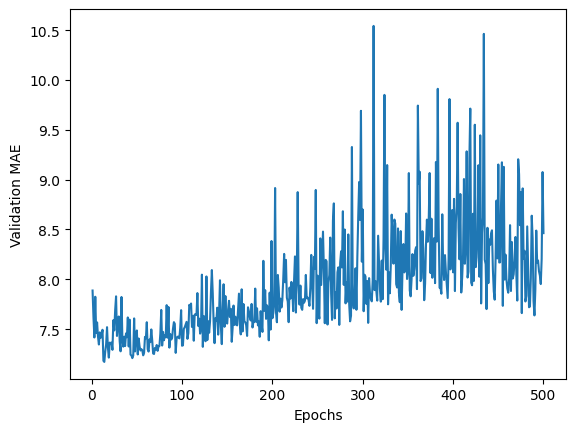

In [46]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# smoothcurve

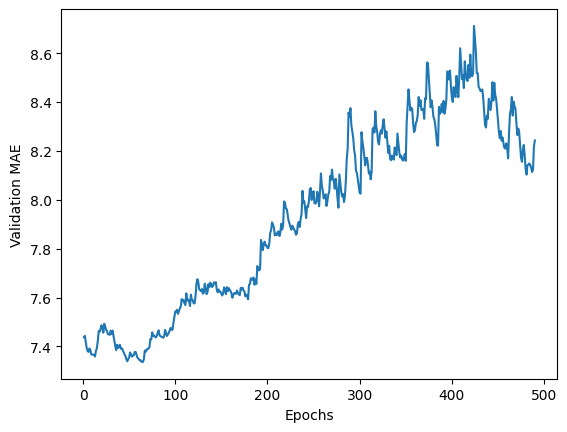

In [47]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# train

In [22]:
# Get a fresh, compiled model.
#model = build_model()
# Train it on the entirety of the data.
#h=model.fit(train_data, train_targets,epochs=70, batch_size=16, verbose=1)
#model.save('adultmodel.h5')

model = keras.models.load_model('adultmodel.h5')

# 預測結果
#test_pred = model.predict(test_data)

# 評估模型表現
score= model.evaluate(test_data, test_targets)
score2= model.evaluate(train_data, train_targets)
print('mae:', score[1])
print('mse:', score[2])
print('mape:', score[3])


943/943 [==============================] - 2s 2ms/step - loss: 104.0383 - mae: 6.8943 - mse: 104.0383 - mape: 23.9569
mae: 7.238255023956299
mse: 114.61593627929688
mape: 25.85418128967285
